Generate Synthetic Network for OD Estimation Problem

- Simple network with e.g. 3 junction at each an off-ramp and an on-ramp
- Network edge features: length and speed limit
- All road uni-directional in simple toy example - we can extend this later to more complex case of bi-directional roads
- Distinction between fast (main) roads and slow (off/on ramps, minor roads) - this may be more important when route choice introduced
- Output the path incidence matrix and assignment matrix assuming no route choice beyond shortest path
- Generate an OD matrix for the system - e.g. randomly or through some distribution function
- Translate OD matrix to
    - Actual edge level flow
    - INRIX like flow - give x% sample of vehicles in OD matrix a tracker and record their flow
    - MIDAS - record all vehicles at certain points on the network

In [136]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import randrange, uniform

def add_gaussian_noise(traffic_data, mean=0, std_dev=1):
    noise = np.random.normal(mean, std_dev)
    return traffic_data + noise

<function matplotlib.pyplot.show(close=None, block=None)>

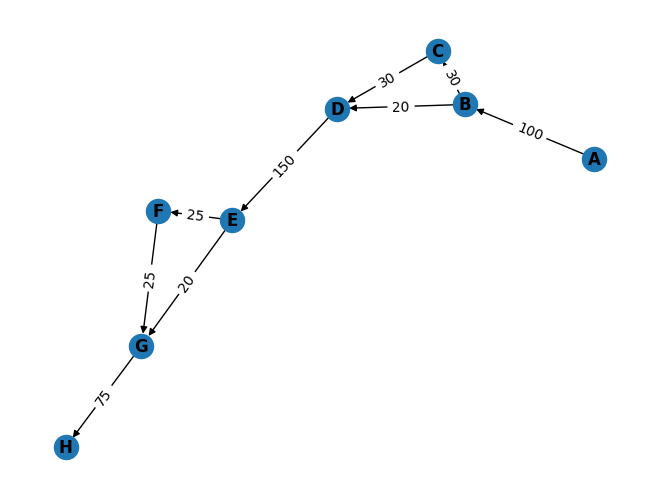

In [8]:
# Create network with 3 junctions

# Create an empty graph
G = nx.DiGraph()

# Add nodes
nodes = ['A','B','C','D','E','F','G','H']
G.add_nodes_from(nodes)

fast_road_sl = 60
slow_road_sl = 30

# Add Edges
edges = [
    #Main road edges
    ('A','B',{'length': 100, 'speed limit': fast_road_sl}),
    ('B','D',{'length': 20, 'speed limit': fast_road_sl}),
    ('D','E',{'length': 150, 'speed limit': fast_road_sl}),
    ('E','G',{'length': 20, 'speed limit': fast_road_sl}),
    ('G','H',{'length': 75, 'speed limit': fast_road_sl}),
    
    #Slow on/off ramps
    ('B','C',{'length': 30, 'speed limit': slow_road_sl}),
    ('C','D',{'length': 30, 'speed limit': slow_road_sl}),
    ('E','F',{'length': 25, 'speed limit': slow_road_sl}),
    ('F','G',{'length': 25, 'speed limit': slow_road_sl})
]

G.add_edges_from(edges)

#Visualise Network

pos = nx.spring_layout(G)  # positions for all nodes

nx.draw(G, pos, with_labels=True, font_weight='bold')

# Edge labels
edge_labels = nx.get_edge_attributes(G, 'length')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show

In [23]:
# Define edge nodes 

NB = ['A','C','F','H']

# Possible destinations for each edge node

NB_Routes = {}
NB_Routes['A'] = ['C','F','H']
NB_Routes['C'] = ['F','H']
NB_Routes['F'] = ['H']
NB_Routes['H'] = []

In [46]:
# Matrices to describe network
# Note that in simple example we assume no route choice variance for OD pairs
# In this case paths IDs will match OD IDs - which won't be the case when route choice included
# E.g., each OD will have multiple possible paths each with a unique ID
# TODO - this code not designed for considering route choice

routes_sp = {}
paths = {}
ods = {}
od_id = 1
path_id = 1

for o in NB:
    destinations = NB_Routes[o]
    if len(destinations) > 0:
        routes_sp[o] = {}
    for d in destinations:
        routes_sp[o][d]=nx.shortest_path(G,o,d,weight = 'length')
        paths[path_id] = tuple([o,d])
        path_id += 1
        ods[tuple([o,d])] = od_id
        od_id += 1

In [48]:
# Get path incidence - (!Assumption - only consider routes that originate at a border node!)

link_path_matrix = pd.DataFrame(0, index = pd.MultiIndex.from_tuples(list(G.edges) ), columns = list(paths.keys()))

for id in list(paths.keys()):
    path = routes_sp[paths[id][0]][paths[id][1]]
    u = path[0]
    for v in path[1:]:
        edge = tuple([u,v])
        link_path_matrix.loc[edge,id] = 1
        u = v

In [49]:
link_path_matrix

1  2  3  4  5  6
A B  1  1  1  0  0  0
B D  0  1  1  0  0  0
  C  1  0  0  0  0  0
C D  0  0  0  1  1  0
D E  0  1  1  1  1  0
E G  0  0  1  0  1  0
  F  0  1  0  1  0  0
F G  0  0  0  0  0  1
G H  0  0  1  0  1  1

In [ ]:
# Get assignment matrix

In [66]:
# Path Proportion Matrix
# A matrix OD ID on the rows, path ID on columns
# Assign proportion of each OD flow to paths IDs
# In simple case, each OD only assigned to one path
# TODO: code not designed for route choice scenario, below code is a cheat

path_od_proportions = pd.DataFrame(0, index = list(paths.keys()), columns = list(ods.values()))
np.fill_diagonal(path_od_proportions.values, 1)

In [70]:
assignment_matrix = np.matmul(link_path_matrix.values,path_od_proportions.values)

In [71]:
assignment_matrix

array([[1, 1, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 1, 1]])

### Define An OD Matrix on Area of Study

Naive way:
- Define Total number of vehicles in system
- Distribute with some randomness between all OD pairs

More realistic way
- Assign destinations some "attractiveness" level
- Assign origins some popuation score
- Assign ODs according to some gravity like function using above information

In [144]:
# Naive OD Matrix Consturction
num_v = 5000
inrix_sample_rate = 0.05

# Randomly distribute num_v to OD IDS
od_mx = pd.DataFrame(0,index = list(G.nodes), columns= list(G.nodes))
od_vct = np.zeros((len(ods)))
od_vct_inrix = np.zeros((len(ods)))

for i in range(num_v):
    rnd_var = randrange(len(ods))
    next_od = list(ods.keys())[rnd_var]
    od_mx.loc[next_od[0],next_od[1]] += 1
    od_vct[rnd_var] += 1
    if uniform(0, 1) <= inrix_sample_rate:
        od_vct_inrix[rnd_var] += 1

In [110]:
# TODO - Gravity based OD Matrix

In [132]:
# Function to apply flow to network using assignment matrix

actual_flow = np.matmul(assignment_matrix , od_vct)

In [134]:
#TODO plot on edges as heatmap

### Sensor Readings

1. INRIX sensors
    - Randomly sample agents in OD matrix as being instrumented
    - Apply to edges
2. MIDAS
    - Sense all traffic in set places on network with some smallish error term

In [147]:
inrix_observed_flow = np.matmul(assignment_matrix , od_vct_inrix)

In [192]:
#Taking MIDAS edge as the stretch of road between junction off and on ramps. This closely resembles real-world location of sensors in short straights.
#MIDAS edge : BD, EG
#MIDAS indexes : 1,5

midas_flow1 = add_gaussian_noise(actual_flow[1], mean=0, std_dev=250)
midas_flow2 = add_gaussian_noise(actual_flow[5], mean=0, std_dev=250)